In [74]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [75]:
# Open dataset and normalize data
df = pd.read_csv('joesley_day.csv', index_col=['Date'])
df = df.loc['2017-01-16':'2017-05-24', :]

#df_norm = np.log(df / df.shift(1)).dropna()
df_norm = df.pct_change().dropna()

print(df_norm.shape)
df_norm.tail()

(89, 44)


,ARGT,COLO,ECH,EDEN,EFNL,EIDO,EIRL,EIS,ENZL,EPHE,EPOL,EPU,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWK,EWL,EWM,EWN,EWO,EWP,EWQ,EWS,EWT,EWU,EWW,EWY,EWZ,EZA,GREK,INDA,KSA,MCHI,NORW,QAT,SPY,THD,TUR,UAE,VNM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-18,-0.027677,-0.013065,-0.019476,0.003962,-0.001299,0.005805,0.003750,0.004426,-0.003956,-0.010492,-0.010566,-0.014109,0.002331,0.000388,-0.007160,0.001635,0.005616,0.006095,0.002668,-0.012328,0.002336,-0.000315,0.002418,-0.000487,-0.003677,0.000345,0.002980,0.001763,0.003200,-0.015525,0.000917,-0.163260,-0.015649,0.010582,-0.011728,0.004425,0.002100,-0.004991,0.000000,0.004028,0.001302,-0.015909,0.020735,-0.008590
2017-05-19,0.021687,0.021385,0.013951,0.012989,0.020297,0.053867,0.012374,0.004214,0.009577,0.021485,0.032465,0.020152,0.008837,0.018210,0.016226,0.010774,0.000859,0.016394,0.008172,0.015976,0.014564,0.011646,0.011027,0.029211,0.023985,0.013113,0.010611,0.012614,0.010151,0.025232,0.019856,0.067481,0.027009,0.006283,0.007495,0.001602,0.014482,0.016872,0.023069,0.006504,0.010663,0.031050,0.009286,0.014440
2017-05-22,-0.002653,-0.002991,-0.001632,0.007953,0.003570,-0.006572,0.005074,0.002289,0.007635,0.000273,0.004965,0.002290,0.007377,0.005708,0.001183,0.001938,-0.000858,0.005961,-0.000566,-0.002948,0.005742,0.004045,0.006816,0.011353,-0.005405,0.003747,0.000840,0.001449,0.000287,-0.003076,0.004493,-0.027746,0.003662,0.013527,-0.005269,0.000800,0.011458,0.003139,-0.011012,0.005077,0.002959,0.001991,-0.012651,-0.000712
2017-05-23,0.001330,-0.002000,-0.000468,-0.000322,0.010165,-0.007718,0.000000,-0.004949,0.002526,-0.001638,-0.018114,-0.009140,0.000000,-0.001514,0.007088,-0.001289,0.001289,-0.000348,0.001320,-0.001479,-0.003140,-0.000930,-0.002708,-0.000468,0.009964,-0.002375,-0.002518,-0.002893,-0.003157,0.004821,-0.004026,0.023831,0.021393,-0.005133,-0.014646,-0.003995,-0.006314,0.008494,-0.001061,0.002213,0.001796,0.012916,0.004077,-0.000712
2017-05-24,0.010628,0.004008,0.010984,0.003866,0.009057,-0.007407,-0.000918,0.005356,0.005726,0.004650,0.018029,-0.000865,0.001373,0.000758,0.001760,0.000968,0.004719,-0.002092,-0.001507,0.002468,-0.001718,0.004032,0.001358,0.010763,0.001196,0.001701,0.005890,0.004642,0.001152,0.019194,0.006287,0.010920,0.010879,-0.029928,0.003479,-0.000602,0.000561,0.001330,0.000000,0.002333,0.003714,0.004169,-0.003480,0.013542


In [76]:
# Definir a data da notícia (tratamento)
treatment_date = "2017-05-17"
t0 = df_norm.index.get_loc(treatment_date)

In [77]:
# Série tratada
Y1 = df_norm["EWZ"].values

In [78]:
# Controles
donors = df_norm.drop(columns=["EWZ"])
Y0 = donors.values.T  # (unidades x tempo)

In [79]:
T0 = t0  # número de períodos pré-tratamento
Y1_pre = Y1[:T0]
Y0_pre = Y0[:, :T0]  # shape

k = Y0_pre.shape[0]  # número de controles

# Função objetivo: minimizar o erro quadrático
def objective(w):
    Y_synth = w @ Y0_pre
    return np.sum((Y1_pre - Y_synth) ** 2)

# Restrições:
# 1) soma dos pesos = 1
cons = ({
    "type": "eq",
    "fun": lambda w: np.sum(w) - 1
})

# 2) pesos >= 0
bounds = [(0, 1) for _ in range(k)]

# chute inicial (uniforme)
w0 = np.ones(k) / k

res = minimize(
    objective,
    w0,
    method="SLSQP",
    bounds=bounds,
    constraints=cons
)

weights = res.x


In [80]:
EWZ_synth = weights @ Y0
impact = Y1[T0+1] - EWZ_synth[T0+1]
impact

np.float64(-0.14563630816820927)

In [114]:
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) if w > 0
}
selected

{'ARGT': np.float64(0.215),
 'EPU': np.float64(0.098),
 'EWA': np.float64(0.024),
 'EWW': np.float64(0.318),
 'EZA': np.float64(0.342),
 'TUR': np.float64(0.003)}

In [115]:
list_countries = list(selected.keys())
list_countries.append('EWZ')
list_countries

df_norm.loc[:treatment_date, list_countries].corr()['EWZ']

ARGT    0.700022
EPU     0.608035
EWA     0.645099
EWW     0.687955
EZA     0.658065
TUR     0.462465
EWZ     1.000000
Name: EWZ, dtype: float64

We estimate w by OLS for all the q equations.3 Note that Abadie et al. (2010) approach
consider that the weights should be non-negative and their sum should be equal to one.
These restrictions provide a possible interpretation for the weights. However, Carvalho
et al. (2015) argues that it is not clear the relevance of the interpretation when all that
is needed is a strong correlation. For example, consider an extreme case where there is
a perfectly negatively correlated country with Brazil. Under the restrictions adopted by
Abadie et al. (2010), this peer would be disregarded despite the fact that using it would
result in an almost perfect synthetic counterfactual. The opposite case is also troublesome,
consider that all the peers are uncorrelated to Brazil. Due to the restriction to sum to
one, the estimator automatically assign weights to countries that have no contribution in
explaining the counterfactual trajectory.  
FX interventions in Brazil: a synthetic control approach∗, Marcos Chamon, Marcio Garcia, Laura Souza 

In [116]:


# Série tratada
y = df_norm.loc[:treatment_date, "EWZ"].values

# Donors (sem constante)
X = donors.loc[:treatment_date, ].values

# Estima OLS sem intercepto
ols_model = sm.OLS(y, X).fit()

weights = ols_model.params
weights


array([ 0.42956339, -0.11381091, -0.29745841,  0.40681749, -0.19946748,
       -0.34003328, -0.14190439,  0.05536317,  0.4385094 , -0.33941714,
       -0.46273797,  0.31311674, -0.21581696,  0.27738768,  0.56745237,
        0.77927153, -0.16610564, -0.03541831,  0.38073785,  1.20911963,
        0.25205717,  0.81453142,  0.01629272,  0.08427759, -1.07102273,
        0.44987831,  0.16608926,  0.2166198 , -0.30907368,  0.55296551,
       -0.23876715,  0.19322388, -0.15946667, -0.07957155,  0.06383666,
        0.37768236, -0.95332743,  0.47414123,  0.35941283, -0.20018883,
       -0.09625452, -0.15867541, -0.23108997])

In [117]:
EWZ_synth_ols = weights @ Y0
impact = Y1[T0+1] - EWZ_synth_ols[T0+1]
impact

np.float64(-0.1413131125122579)

In [118]:
mse = mean_squared_error(Y1[:T0], EWZ_synth_ols[:T0])
rmse = round(np.sqrt(mse), 6)

print(round(mse, 4), round(rmse, 5)) #0.011370461757934283

0.0001 0.00712


In [119]:
mse = mean_squared_error(Y1[:T0], EWZ_synth[:T0])
rmse = np.sqrt(mse)

print(mse, rmse) #0.011370461757934283

0.00012928740058864598 0.011370461757934283


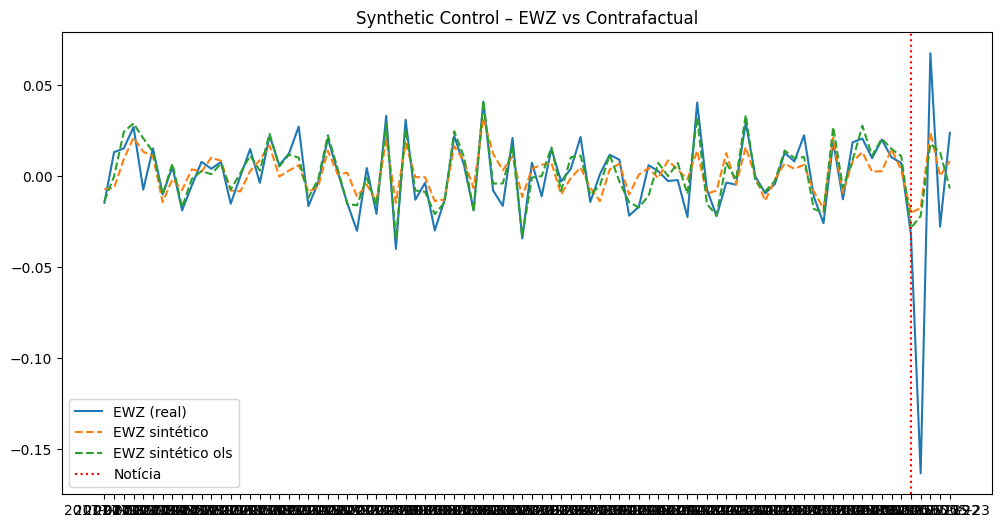

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_norm.index, Y1, label="EWZ (real)")
plt.plot(df_norm.index, EWZ_synth, label="EWZ sintético", linestyle="--")
plt.plot(df_norm.index, EWZ_synth_ols, label="EWZ sintético ols", linestyle="--")
plt.axvline(df_norm.index[t0], color="red", linestyle=":", label="Notícia")
plt.legend()
plt.title("Synthetic Control – EWZ vs Contrafactual")
plt.show()


---

https://doi.org/10.1080/13504851.2022.2140750